In [1]:
import pandas as pd
from biom import load_table
import matplotlib.pyplot as plt
import numpy as np
from skbio import TreeNode
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

In [2]:
metadata = pd.read_table('../data/ag_map_with_alpha.txt', index_col=0)
table = load_table('../data/ag_plants.biom')
ids = pd.read_table('../data/plants.ids', dtype=np.str, header=None)
tree = TreeNode.read('../data/ag_tree.tre')

obs_ids = table.ids(axis='observation')
taxa = [table.metadata(id=i, axis='observation')['taxonomy'] for i in obs_ids]
taxa = pd.DataFrame(taxa, index=obs_ids, 
                    columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species'])

/Users/mortonjt/miniconda3/envs/bio/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (0,66) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Here we will perform some filtering based on low abundance, sparsity and variance

In [3]:
otu_filter = lambda val, id_, md: val.sum() > 10
var_filter = lambda val, id_, md: np.var(val) > 10
sparse_filter = lambda val, id_, md: (val>0).sum() > 10
id_filter = lambda val, id_, md: id_ in ids[0].values
table = table.filter(id_filter, axis='sample')
table = table.filter(otu_filter, axis='observation')
#table = table.filter(var_filter, axis='observation')
table = table.filter(sparse_filter, axis='observation')

table = pd.DataFrame(np.array(table.matrix_data.todense()).T, 
                     index=table.ids(axis='sample'),
                     columns=table.ids(axis='observation'))

Now we will clean the labels, merge together the categories "Less than 5" and "6 to 10" together. We'll only compare those categories to "More than 30", so we'll drop the other categories.

In [4]:
from gneiss.util import match
def preprocess_plants(x):
    if x in 'Less than 5' or x in '6 to 10':
        return 'Less than 10'
    elif x in 'More than 30':
        return 'More than 30'
    else:
        return np.nan
metadata['cleaned_plants'] = metadata.types_of_plants.apply(preprocess_plants)
metadata = metadata.dropna(subset=['cleaned_plants'])
table, metadata = match(table, metadata)

In [5]:
metadata.cleaned_plants.value_counts()

Less than 10    35
More than 30    33
Name: cleaned_plants, dtype: int64

In [6]:
from sklearn.exceptions import ConvergenceWarning
from skbio.stats.composition import closure
from sklearn.linear_model import (LogisticRegressionCV,
                                  RandomizedLogisticRegression)
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import preprocessing
from skbio.stats.composition import clr, centralize, multiplicative_replacement
from numpy.random import RandomState

le = preprocessing.LabelEncoder()
le.fit(metadata.cleaned_plants)
y = le.transform(metadata.cleaned_plants)
clf = ExtraTreesClassifier(100, random_state=0)
clf.fit(table.values, y)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

In [7]:
table = table.loc[:, clf.feature_importances_>0.004]

In [8]:
tree = tree.shear(table.columns)

In [9]:
from gneiss.util import rename_internal_nodes
tree = rename_internal_nodes(tree)

In [10]:
from gneiss.composition import ilr_transform
from skbio.stats.composition import clr, centralize, multiplicative_replacement
from gneiss.cluster import correlation_clustering
ctable = pd.DataFrame(multiplicative_replacement(table),
                      index=table.index, columns=table.columns)
#tree = correlation_clustering(ctable)
balances = ilr_transform(ctable, tree)

In [11]:
from gneiss.regression import ols
res = ols("C(country)+C(types_of_plants)", balances, metadata)
res.fit() 

In [12]:
res.pvalues.loc['C(types_of_plants)[T.More than 30]'].sort_values().head()

y20    0.001979
y16    0.002476
y22    0.004234
y33    0.004266
y15    0.004625
Name: C(types_of_plants)[T.More than 30], dtype: float64

In [13]:
y = res.pvalues.apply(np.argmin, axis=1)['C(types_of_plants)[T.More than 30]']

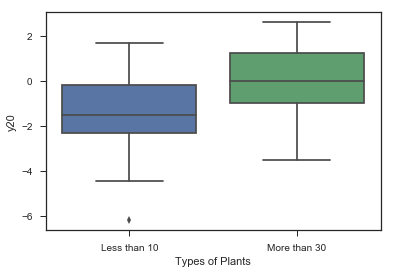

In [14]:
import seaborn as sns
data = pd.merge(balances, metadata, left_index=True, right_index=True)
fig = plt.figure()
sns.boxplot(y=y, x='cleaned_plants', data=data, order=['Less than 10', 'More than 30'])
plt.xlabel('Types of Plants')
fig.savefig('plants.pdf')

In [25]:
from gneiss.util import NUMERATOR, DENOMINATOR
# we'll flip this for the plots
num = list(tree.find(y).children[DENOMINATOR].subset())
denom = list(tree.find(y).children[NUMERATOR].subset())

In [26]:
def f(x):
    tabs = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    x_ = x
    for i in range(1, len(x)):
        if x[i] in tabs:
            x_[i] = x[i-1]
    return x_
taxa = taxa.loc[num+denom]
taxa = taxa.apply(f, axis=1)

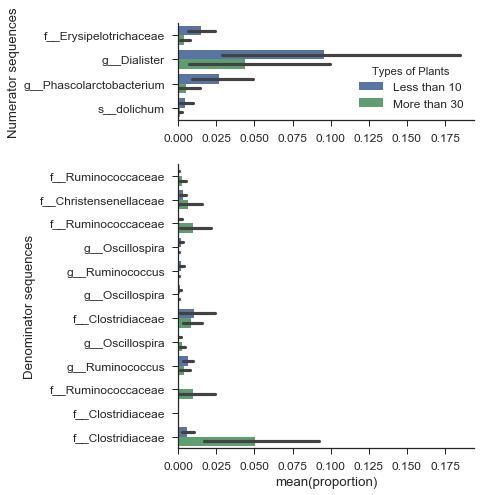

In [27]:
import seaborn as sns
sns.set_style('ticks')
from matplotlib.gridspec import GridSpec
gs = GridSpec(100, 100)
plt.figure(figsize=(7, 7))
ax1 = plt.subplot(gs[:30, :])
ax2 = plt.subplot(gs[30:, :], sharex=ax1)

sns.set_style('ticks')
sns.set(font_scale=1.2)  # crazy big
level = 'species'
ctable = pd.DataFrame(closure(table), index=table.index, columns=table.columns)
cmetadata = metadata.copy()
cmetadata['Types of Plants'] = metadata[['cleaned_plants']]
data_num = pd.merge(ctable[num], cmetadata[['Types of Plants']], left_index=True, right_index=True)
data_denom = pd.merge(ctable[denom], cmetadata[['Types of Plants']], left_index=True, right_index=True)
#data = pd.concat((data_num, data_denom.iloc[:, :-2]), axis=1)

data_num = pd.melt(data_num, id_vars=['Types of Plants'], value_vars=num, 
                   value_name='proportion', var_name='Numerator sequences')
data_denom = pd.melt(data_denom, id_vars=['Types of Plants'], value_vars=denom, 
                     value_name='proportion', var_name='Denominator sequences')

#data['location'] = data.sequence.apply(lambda x: 'numerator' if x in num else 'denominator')
data_num = data_num.dropna(subset=['proportion'])

data_denom = data_denom.dropna(subset=['proportion'])

g = sns.barplot(x='proportion', hue='Types of Plants', 
                y='Numerator sequences', 
                data=data_num,
                #palette={'More than 30': 'green', 'Less than 10': '#F7CE2B'},
                #order=['Less than 10', 'More than 30'],
                ax=ax1
)
_ = g.set(yticklabels=taxa.loc[num, level].values)
_ = g.set(xlabel="")

g = sns.barplot(x='proportion', hue='Types of Plants', 
                y='Denominator sequences', 
                data=data_denom,
                #palette={'More than 30': 'green', 'Less than 10': '#F7CE2B'},
                #order=['Less than 10', 'More than 30'],
                ax=ax2
)
_ = g.set(yticklabels=taxa.loc[denom, level].values, )
plt.tight_layout()
ax2.legend_.remove()
# ax2.set_xticklabels('')
sns.despine()
plt.savefig('Types_of_Plants_barplot.pdf')

In [28]:
import seaborn as sns
from matplotlib.gridspec import GridSpec

#sns.set_style('ticks')
sns.set(font_scale=1.1)  # crazy big

ctable = pd.DataFrame(closure(table), index=table.index, columns=table.columns)
cmetadata = metadata.copy()
cmetadata['Types of Plants'] = metadata[['cleaned_plants']]
data_num = pd.merge(ctable[num], cmetadata[['Types of Plants']], left_index=True, right_index=True)
data_denom = pd.merge(ctable[denom], cmetadata[['Types of Plants']], left_index=True, right_index=True)
data = pd.concat((data_num, data_denom.iloc[:, :-2]), axis=1)
data = pd.melt(data, id_vars=['Types of Plants'], value_vars=num+denom, 
               value_name='proportion', var_name='sequence')

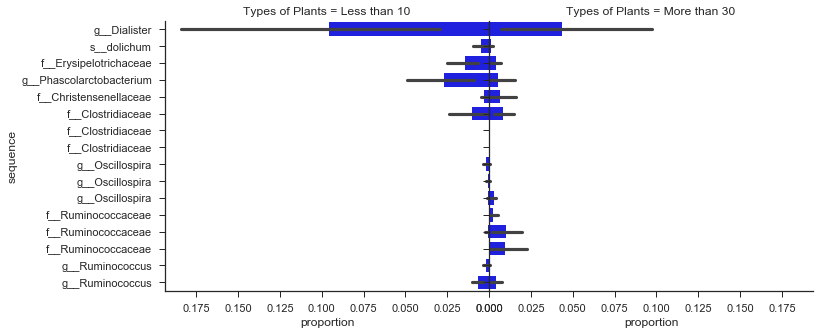

In [29]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
level='species'
sns.set_style('ticks')
#data['location'] = data.sequence.apply(lambda x: 'numerator' if x in num else 'denominator')
data = data.dropna(subset=['proportion'])
data['log_proportion'] = np.log(data['proportion']+1e-5)

num_idx = np.argsort(list(map(lambda x: x[3:].lower(), taxa.loc[num, level].values)))
num_taxa = taxa.loc[[num[i] for i in num_idx], level]

denom_idx = np.argsort(list(map(lambda x: x[3:].lower(), taxa.loc[denom, level].values)))
denom_taxa = taxa.loc[[denom[i] for i in denom_idx], level]

g = sns.factorplot(x='proportion',  
                   y='sequence', 
                   col='Types of Plants',
                   data=data,
                   kind='bar',
                   size=5,
                   aspect=1.5,
                   color='b',
                   col_order=['Less than 10', 'More than 30'],
                   order=list(num_taxa.index)+list(denom_taxa.index),
                   #hue='Types of Plants',
                   sharex=False
)
_ = g.set(yticklabels=taxa.loc[list(num_taxa.index)+list(denom_taxa.index), level].values)
[[ax1, ax2]] = g.axes
max_xlim = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
min_xlim = max(ax1.get_xlim()[0], ax2.get_xlim()[0])
xlim = ([min_xlim, max_xlim])
ax1.set_xlim(max_xlim, min_xlim)
ax2.set_xlim(min_xlim, max_xlim)
#_ = g.set(xlabel="")
ax1.set_position([0.2, 0.125, 0.3, 0.75])
ax2.set_position([0.5, 0.125, 0.3, 0.75])

# plt.tight_layout()
plt.savefig('Types_of_Plants_cool.pdf')